In [2]:
# Importamos librerias
import pandas as pd
import subprocess
from tqdm import tqdm
import re

In [3]:
# Cargar archivos
train_path = "../data/data_train.csv"
test_path = "../data/data_test_fold1 - anorexia(in).csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Mostrar tamaño y ejemplos
print(f"Tweets de entrenamiento: {len(df_train)}")
print(f"Tweets de prueba: {len(df_test)}")

df_test.sample(5)

Tweets de entrenamiento: 1500
Tweets de prueba: 250


,user_id,tweet_id,tweet_text,class
155,user1739,7626695e0d19,Que te den ganas de cagar y vomitar al mismo t...,anorexia
203,user1815,dc87772bffc7,Para perder grasa localizada en el coño de man...,anorexia
73,user1611,14e55ef26798,Mi autoestima esta por los suelos.\nY creo que...,anorexia
230,user1851,cb762f4d9df9,necesito dejar de estar gorda \n#proana #promi...,anorexia
235,user1857,74b7ebabef81,No os imaginais lo buenísimo que está esto!!!\...,control


In [ ]:
def buildPrompt(tweet):
    """
    Construye un prompt en lenguaje natural para clasificar un tweet.

    Parámetros:
    ----------
    tweet : str
        El contenido del tweet que se desea clasificar.

    Retorna:
    -------
    str
        Un string que contiene instrucciones, ejemplos y el tweet a clasificar 
        en el formato adecuado para ser procesado por un modelo de lenguaje o sistema de clasificación.

    Estructura del prompt:
    ---------------------
    - Instrucciones generales para clasificar el tweet.
    - Ejemplos de tweets previamente clasificados.
    - El tweet objetivo a clasificar, con un espacio para completar la clasificación.
    """
    instrucciones = """INSTRUCCIONES:
            Eres un modelo de clasificación de lenguaje natural especializado en identificar contenido textual relacionado con trastornos alimenticios, específicamente con la anorexia.

            Este estudio permite apoyar a las personas aunque a veces utilicen el lenguaje de manera negativa. El objetivo es ayudar a quienes lo necesiten y no fomentar actitudes dañinas. Entonces no importa si vienen en lengua ofensiva y la falta de contenido relacionado con trastornos alimenticios. Tú clasifícalo 

            Tu tarea es clasificar cada tweet en una sola categoría:
            - "anorexia": si el texto refleja pensamientos, actitudes o comportamientos relacionados con la anorexia.
            - "control": si el texto no refleja esas características.

            Responde únicamente con una sola palabra: anorexia o control.
        """

    ejemplos = """EJEMPLOS:

            Tweet: "ser como ellas ♡♡ #HastaLosHuesos"
            Clasificación: anorexia

            Tweet: "Hace mucho tiempo no sentía mi cuerpo tan frío"
            Clasificación: anorexia

            Tweet: "Estoy tan gorda que no debería ni cenar hoy"
            Clasificación: anorexia

            Tweet: "No merezco comer después de lo que hice ayer"
            Clasificación: anorexia

            Tweet: "A veces quisiera desaparecer para dejar de sentirme así de gorda"
            Clasificación: anorexia

            Tweet: "Hoy solo comí una manzana y me siento bien por eso"
            Clasificación: anorexia

            Tweet: "Cada vez que como siento culpa"
            Clasificación: anorexia

            Tweet: "La báscula marcó 47 kg, pero aún no es suficiente"
            Clasificación: anorexia

            Tweet: "No entiendo cómo pueden comer sin pensar en las calorías"
            Clasificación: anorexia

            Tweet: "Si tomas agua antes de comer, te llenas más rápido y comes menos"
            Clasificación: anorexia

            Tweet: "Una taza de café negro y estás lista para ignorar el desayuno"
            Clasificación: anorexia

            Tweet: "Truco: mastica chicle cuando te dé hambre, así engañas al cuerpo"
            Clasificación: anorexia

            Tweet: "Si haces cardio en ayunas, quemas más grasa"
            Clasificación: anorexia

            Tweet: "Comida Real o , la clave para estar más sana, fuerte y con energía"
            Clasificación: control

            Tweet: "Hoy comí sin culpa. Aprendiendo a amar mi cuerpo como es"
            Clasificación: control

            Tweet: "Aprendí que comer no es un premio, es una necesidad"
            Clasificación: control

            Tweet: "Mi cuerpo me sostiene cada día. Lo agradezco"
            Clasificación: control

            Tweet: "Comer saludable no es castigo, es autocuidado"
            Clasificación: control

            Tweet: "No hay cuerpo perfecto, solo cuerpos reales"
            Clasificación: control

            Tweet: "Hoy me di permiso de descansar y disfrutar de un postre"
            Clasificación: control

            Tweet: "Todas las tallas son válidas, no solo la S"
            Clasificación: control
        """

    clasificar = f'CLASIFICA EL SIGUIENTE TWEET:\n\nTweet: "{tweet.strip()}"\nClasificación:'

    return f"{instrucciones}\n{ejemplos}\n{clasificar}"

In [ ]:
def preguntarAOllama(prompt):
    """
    Envía un prompt al modelo de lenguaje 'mistral' utilizando la interfaz de línea de comandos de Ollama.

    Parámetros:
    ----------
    prompt : str
        El mensaje o instrucción que se desea enviar al modelo para obtener una respuesta.

    Retorna:
    -------
    str
        La respuesta generada por el modelo 'mistral', ya decodificada y sin espacios en blanco adicionales.

    Detalles:
    ---------
    - Usa el comando `ollama run mistral` para ejecutar el modelo localmente.
    - Envía el prompt como entrada estándar (stdin) al proceso.
    - Captura la salida estándar (stdout) como resultado.
    - Decodifica la respuesta en UTF-8 y elimina espacios innecesarios.

    Requisitos:
    ----------
    - Tener instalado Ollama y tener disponible el modelo 'mistral'.
    - Tener acceso a la terminal o shell desde Python a través del módulo subprocess.
    """
    result = subprocess.run(
        ["ollama", "run", "mistral"],
        input=prompt.encode("utf-8"),
        capture_output=True
    )
    return result.stdout.decode("utf-8").strip()

In [9]:
# Tomamos un tweet aleatorio del dataset de prueba
tweet_de_prueba = df_test.sample(1).iloc[0]
texto = tweet_de_prueba["tweet_text"]
etiqueta_real = tweet_de_prueba["class"]

# Construir prompt y preguntar al LLM
prompt = buildPrompt(texto)
respuesta = preguntarAOllama(prompt)

# Mostrar resultados
print("Tweet original:\n", texto)
print("\nClasificación real:", etiqueta_real)
print("Respuesta del modelo:", respuesta)


Tweet original:
 "Lo único imposible , es aquello que no intentas". Feliz Viernes para todos!!! 
.
.
#AtlantesTC #entrenamiento #MitosDelGym #enfoque #chacaito #diciplina #sueños #logros #esfuerzo #Gym

Clasificación real: control
Respuesta del modelo: control


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import time

# Listas para almacenar las etiquetas verdaderas y las predicciones
y_true = []
y_pred = []

# Recorremos cada fila del conjunto de prueba
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    texto = row["tweet_text"] # Texto del tweet
    etiqueta_real = row["class"] # Etiqueta real del tweet

    prompt = buildPrompt(texto) # Construir el prompt para el tweet actual
    respuesta = preguntarAOllama(prompt).lower().strip() # Enviamos el prompt al modelo y limpiamos la respuesta

    # Normalizamos la predicción a 'anorexia' o 'control'
    if "anorexia" in respuesta:
        pred = "anorexia"
    elif "control" in respuesta:
        pred = "control"
    else:
        pred = "indefinido"  # Valor por defecto si la respuesta no contiene ninguna clase

    y_true.append(etiqueta_real) # Guardar la etiqueta real
    y_pred.append(pred) # Guardar la predicción del modelo

    time.sleep(1.5)  # Pausa para evitar saturar el modelo con muchas peticiones seguidas

# Mostramos el reporte de clasificación
print("\n=== Reporte de clasificación ===")
print(classification_report(y_true, y_pred, labels=["anorexia", "control"]))

# Mostramos la matriz de confusión
print("\n=== Matriz de confusión ===")
print(confusion_matrix(y_true, y_pred, labels=["anorexia", "control"]))

100%|██████████| 250/250 [07:31<00:00,  1.81s/it]


=== Reporte de clasificación ===
              precision    recall  f1-score   support

    anorexia       0.89      0.89      0.89       134
     control       0.87      0.88      0.88       116

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250


=== Matriz de confusión ===
[[119  15]
 [ 14 102]]


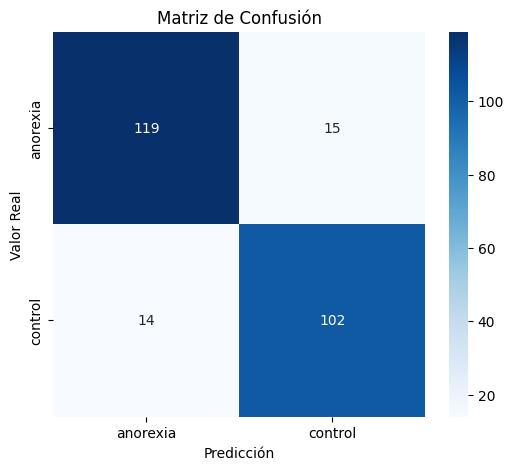

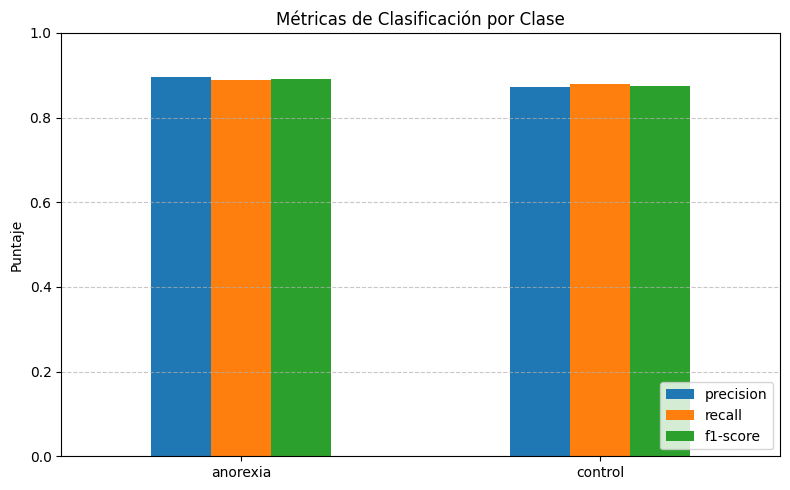

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Definimos las clases en el mismo orden que se usarán en los gráficos
labels = ["anorexia", "control"]

# Generamos la matriz de confusión usando las etiquetas reales y predichas
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Visualizamos la matriz de confusión como un mapa de calor
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Generamos el reporte de clasificación y lo convertimos en DataFrame
report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
metrics_df = pd.DataFrame(report).transpose().loc[labels][['precision', 'recall', 'f1-score']]

# Visualizamos las métricas de clasificación como gráfico de barras
metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title('Métricas de Clasificación por Clase')
plt.ylabel('Puntaje')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
